# Base model for recommendation system

Outline:
1. Database connection. Data preprocessing. #postgresql

2. Feature extraction from unlabeled text (labels were removed for later accuracy evaluation). #tfidf #pca

3. Model training and evaluating #catboost

4. Model saving and feature uploading to server

tl;dr:
- Catboost TF-IDF+PCA was chosen as the base model (ROC-AUC=0.67)
- Let's try to enhance the result by implementing more sophisticated feature extraction techniques (BERT embeddings clusterization) and additional catboost tuning. See enhanced_model.ipynb

## 1. Connect to DB

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


CONN = "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"\
    "postgres.lab.karpov.courses:6432/startml"

In [5]:
# User data

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    con=CONN
)

# user_info = pd.read_csv('data/user_info.csv', index_col=0)
print(user_info.shape)
user_info.sample(5)

(163205, 8)


,user_id,gender,age,country,city,exp_group,os,source
58890,62620,1,27,Russia,Shakhty,0,Android,ads
32415,32636,1,18,Russia,Uzlovaya,4,iOS,ads
90051,94068,1,37,Russia,Moscow,2,Android,ads
85872,89796,0,23,Ukraine,Chernivtsi,1,Android,ads
3508,3707,0,28,Russia,Bogotol,3,iOS,ads


In [6]:
# Posts and topics

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    con=CONN
)

# posts_info = pd.read_csv('data/posts_info.csv', index_col=0)

print(posts_info.shape)
posts_info.sample(5)

(7023, 3)


,post_id,text,topic
5369,5588,Zombi 3 has an interesting history in its maki...,movie
6943,7231,There is a need for this kind of entertainment...,movie
2756,2219,PC photo printers challenge pros\n\nHome print...,tech
894,777,Double eviction from Big Brother\n\nModel Capr...,entertainment
472,414,US adds more jobs than expected\n\nThe US econ...,business


In [7]:
# Feed data

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 1000000""",
    con=CONN
)

# feed_data = pd.read_csv('data/feed_data.csv', index_col=0)

# remove likes
feed_data = feed_data[feed_data.action == 'view']

print(feed_data.shape)
feed_data.sample(5)

(893120, 5)


,timestamp,user_id,post_id,action,target
286349,2021-10-17 18:42:45,49232,5573,view,0
536950,2021-11-07 06:47:15,159398,2870,view,0
81497,2021-12-08 12:01:26,49178,4067,view,0
380113,2021-10-16 13:30:42,159356,1240,view,0
654526,2021-12-22 14:31:25,146994,3003,view,1


## 2. Feature extraction

## 2.1 Text -> TF-IDF

In [5]:
import re
import string

from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line


tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [6]:
tfidf_data = (
    tfidf
    .fit_transform(posts_info['text'])
    .toarray()
)

tfidf_data.shape

c:\Users\grokh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  warnings.warn(


(7023, 46000)

In [7]:
tfidf_data = pd.DataFrame(
    tfidf_data,
    index=posts_info.post_id,
    columns=tfidf.get_feature_names_out()
)

tfidf_data.sample(10)

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2749,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 Extract features from TF-IDF vector space

### 2.2 Reduce dimensionality of TF-IDF with PCA

In [8]:
from sklearn.decomposition import PCA

def get_PCA(n_components, data):
    centered = data - data.mean()
    pca = PCA(n_components) 
    return pca.fit_transform(centered)

# choose big value of n_components to cover as much variance as possible
pca_decomp = get_PCA(n_components = 100, data=tfidf_data)
pd.DataFrame(pca_decomp).sample(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
321,-0.064341,0.053708,-0.020432,-0.067135,-0.042410,-0.033569,-0.000631,-0.011070,-0.034852,0.008631,...,-0.014289,0.006512,-0.000856,0.049403,-0.000864,-0.018231,0.004555,0.002510,0.026885,-0.001975
3041,-0.094523,-0.052727,0.015046,0.025213,0.005182,-0.004767,0.004175,-0.013589,-0.023294,-0.017054,...,-0.002760,0.002037,0.013926,0.016967,-0.020958,0.011973,0.042019,0.007305,0.020246,0.014311
2847,-0.169515,-0.162063,0.039197,0.056482,0.000395,0.020966,0.003944,0.041094,0.044499,0.007587,...,0.002629,0.007612,0.009898,-0.001189,0.000152,-0.006268,-0.020994,-0.013283,0.013013,-0.006924
350,-0.086296,-0.065858,0.013162,0.003228,-0.002244,0.013585,-0.021440,-0.024147,-0.012434,-0.022077,...,-0.069687,0.046087,-0.048896,0.043861,-0.006932,0.022563,-0.049819,-0.054255,0.028199,-0.017672
4549,0.092978,-0.002936,-0.116042,0.066236,-0.001745,0.000020,0.036567,-0.002364,-0.011167,-0.009984,...,0.006164,-0.039789,0.024330,-0.035493,0.020582,0.010571,-0.017679,0.027780,-0.007912,-0.042968


### Get Features of chosen method

In [9]:
def get_features(df, method):
    methods = {
        # 'kmeans': kmeans.transform,
        'pca' : lambda x: x
    }

    data = methods[method](df) if method!=None else df

    if method=='pca':
        columns = [f"PC_{i}" for i in range(0, data.shape[1])]
    else:
        columns = [f"DistanceTo{i}thCluster" for i in range(0, data.shape[1])]

    return pd.DataFrame(
        data=data,
        columns=columns
    )

dists_df = get_features(pca_decomp, 'pca')
dists_df.sample(5)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,...,PC_90,PC_91,PC_92,PC_93,PC_94,PC_95,PC_96,PC_97,PC_98,PC_99
4819,0.063933,0.003138,-0.017426,-0.006721,0.064650,-0.004170,-0.019794,0.118209,-0.052579,-0.058392,...,0.008232,0.009457,0.015131,-0.012743,0.030658,0.012361,-0.009425,0.028742,-0.022831,-0.006888
328,-0.065333,0.144874,0.044714,0.036511,-0.018375,-0.023566,0.005040,0.006687,-0.125723,0.080161,...,-0.070474,-0.081538,-0.033548,-0.023452,-0.069236,-0.004143,-0.009053,-0.024431,-0.053247,-0.124940
700,-0.084540,-0.064035,0.001440,-0.000828,0.010998,0.001841,-0.006328,-0.017380,-0.027083,-0.024808,...,0.000697,0.000604,-0.024572,0.014075,0.004713,-0.018495,-0.021269,-0.002575,0.013966,-0.015684
6875,0.132964,-0.068413,0.109548,-0.041543,-0.031757,-0.007962,0.007928,-0.082966,-0.016720,0.001263,...,-0.035246,0.012423,0.041083,-0.008444,0.054641,0.039915,-0.016783,0.041883,0.033772,0.036658
2186,-0.053015,-0.051578,0.006858,0.000378,0.016865,0.003641,-0.017477,0.035634,-0.024986,-0.032857,...,-0.002232,0.028574,0.015134,0.004363,0.006719,0.013616,-0.023393,-0.000807,0.023211,-0.005663


### Merge tables

In [10]:
def merge_tables(dists_df):
    _posts_info = posts_info.join(dists_df)

    df = pd.merge(
        feed_data, _posts_info,
        on='post_id', 
        how='left'
    )

    df = pd.merge(
        df, user_info,
        on='user_id',
        how='left')

    ### Extract addtional features from timestamp

    df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
    df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

    ### remove unnescessary columns
    df = df.drop([
    #    'timestamp', 
        'action',
        'text',
    ],  
        axis=1)


    return df.set_index(['user_id', 'post_id'])

processed_df = merge_tables(dists_df)
print(processed_df.shape)
processed_df.columns

(894723, 112)


Index(['timestamp', 'target', 'topic', 'PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4',
       'PC_5', 'PC_6',
       ...
       'PC_99', 'gender', 'age', 'country', 'city', 'exp_group', 'os',
       'source', 'hour', 'month'],
      dtype='object', length=112)

## 3. Model Training

In [11]:
max(processed_df.timestamp), min(processed_df.timestamp)

('2021-12-29 23:43:15', '2021-10-01 06:01:40')

In [12]:
def prepare_data(df):
    ### Split by 2021-12-15

    df_train = df[df.timestamp < '2021-12-15']
    df_test = df[df.timestamp >= '2021-12-15']

    df_train = df_train.drop('timestamp', axis=1)
    df_test = df_test.drop('timestamp', axis=1)

    X_train = df_train.drop('target', axis=1)
    X_test = df_test.drop('target', axis=1)

    y_train = df_train['target']
    y_test = df_test['target']

    return X_train, y_train, X_test, y_test

In [13]:
dists_df = get_features(pca_decomp, 'pca')
processed_df = merge_tables(dists_df)

# don't forget to drop topic column - it will be used for clustering performance evaluation in the enhanced_model!
processed_df.drop(columns='topic', inplace=True)

In [14]:
### Default Catboost 
from catboost import CatBoostClassifier

catboost_tfidf_pca = CatBoostClassifier(task_type='GPU')

object_cols = [
    'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

X_train, y_train, X_test, y_test = prepare_data(processed_df)

catboost_tfidf_pca.fit(X_train, y_train, object_cols, verbose=False)

In [15]:
from sklearn.metrics import roc_auc_score

print(f"Train ROC-AUC score: {roc_auc_score(y_train, catboost_tfidf_pca.predict_proba(X_train)[:, 1])}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, catboost_tfidf_pca.predict_proba(X_test)[:, 1])}")

Train ROC-AUC score: 0.7123907308881905
Test ROC-AUC score: 0.6704683923739139


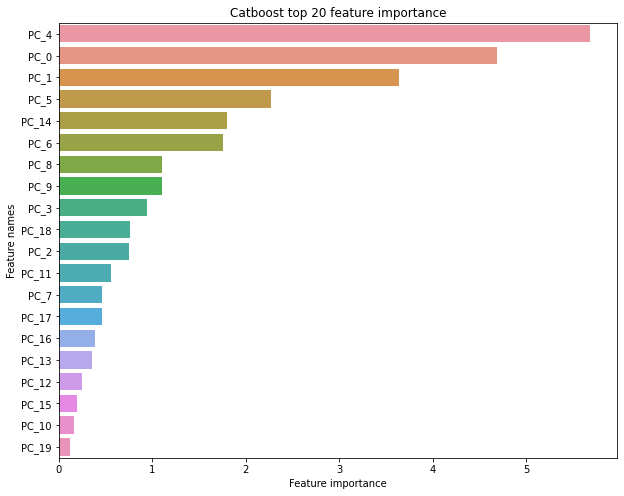

In [16]:

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)[:20]
    feature_names = np.array(names)[:20]
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' top 20 feature importance')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature names')
    
plot_feature_importance(catboost_tfidf_pca.feature_importances_,X_train.columns,'Catboost')

# 4. Saving model and uploading updated features to server

In [17]:
### save model
catboost_tfidf_pca.save_model(
    'catboost_base_model',
    format="cbm"                  
)

In [18]:
posts_info.to_sql(    
   "grokhi_base_model_posts_info_features",                    
    con=CONN,
    schema="public",                   
    if_exists='replace'            
   )                               
                                   

23

In [19]:
test_ = pd.read_sql(
    """SELECT * FROM public.grokhi_base_model_posts_info_features""",
    con=CONN
)

test_

,index,post_id,text,topic
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,2,3,Asian quake hits European shares\n\nShares in ...,business
3,3,4,India power shares jump on debut\n\nShares in ...,business
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...,...
7018,7017,7314,Although the likeliness of someone focusing on...,movie
7019,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7020,7019,7316,I give this movie 2 stars purely because of it...,movie
7021,7020,7317,I cant believe this film was allowed to be mad...,movie
